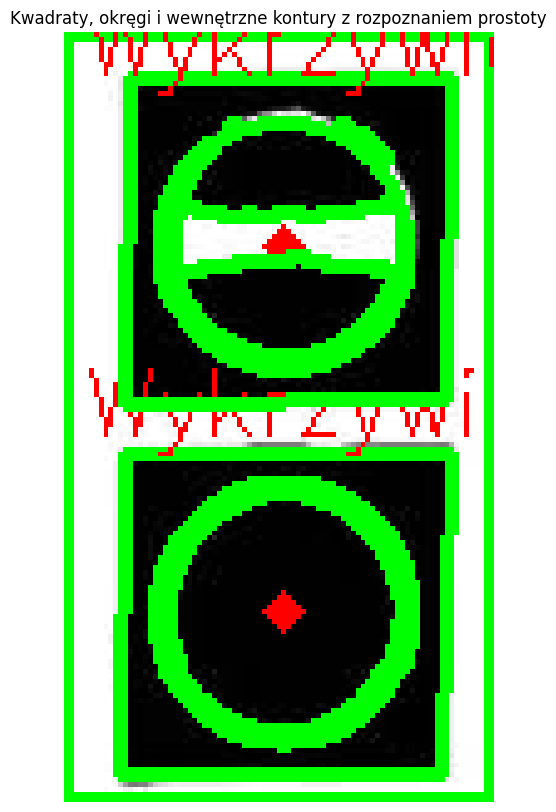

In [2]:

import cv2
import numpy as np
import matplotlib.pyplot as plt

def is_straight(contour, threshold=0.05):
    """Funkcja do sprawdzania, czy kontur jest prosty czy wykrzywiony."""
    arc_length = cv2.arcLength(contour, True)
    area = cv2.contourArea(contour)
    if area == 0:
        return False
    circularity = 4 * np.pi * (area / (arc_length * arc_length))
    return circularity > (1 - threshold)

# 1. Wczytanie obrazu
image_path = 'scheme001.jpg'
image = cv2.imread(image_path)

# Sprawdzenie, czy obraz został poprawnie wczytany
if image is None:
    raise FileNotFoundError(f"Obraz nie został znaleziony w ścieżce: {image_path}")

# Konwersja do skali szarości
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Filtracja wstępna
filtered = cv2.GaussianBlur(gray, (5, 5), 0)

# Wykrycie konturów kwadratów
_, binary = cv2.threshold(filtered, 127, 255, cv2.THRESH_BINARY_INV)
contours, _ = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Przetwarzanie konturów kwadratów
for contour in contours:
    approx = cv2.approxPolyDP(contour, 0.04 * cv2.arcLength(contour, True), True)
    if len(approx) == 4:  # Jeśli kontur ma 4 wierzchołki, może być kwadratem
        x, y, w, h = cv2.boundingRect(approx)
        aspect_ratio = w / float(h)
        if 0.9 <= aspect_ratio <= 1.1:  # Sprawdzenie, czy proporcje są bliskie 1 (kwadrat)
            cv2.drawContours(image, [approx], -1, (0, 255, 0), 2)
            
            # Maskowanie obszaru wewnątrz kwadratu
            mask = np.zeros_like(gray)
            cv2.drawContours(mask, [approx], -1, 255, thickness=-1)
            
            # Znalezienie okręgów wewnątrz maski
            masked_image = cv2.bitwise_and(gray, gray, mask=mask)
            circles = cv2.HoughCircles(masked_image, cv2.HOUGH_GRADIENT, dp=1.2, minDist=50, param1=50, param2=30, minRadius=20, maxRadius=100)
            
            if circles is not None:
                circles = np.uint16(np.around(circles))
                for i in circles[0, :]:
                    # Rysowanie okręgu
                    cv2.circle(image, (i[0], i[1]), i[2], (0, 255, 0), 2)
                    # Rysowanie środka okręgu
                    cv2.circle(image, (i[0], i[1]), 2, (0, 0, 255), 3)
                    
                    # Maskowanie obszaru wewnątrz okręgu
                    inner_mask = np.zeros_like(gray)
                    cv2.circle(inner_mask, (i[0], i[1]), i[2], 255, thickness=-1)
                    
                    # Znalezienie konturów wewnątrz maski
                    inner_masked_image = cv2.bitwise_and(gray, gray, mask=inner_mask)
                    _, inner_binary = cv2.threshold(inner_masked_image, 127, 255, cv2.THRESH_BINARY_INV)
                    inner_contours, _ = cv2.findContours(inner_binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
                    
                    # Rysowanie wewnętrznych konturów i rozpoznawanie prostoty
                    for inner_contour in inner_contours:
                        cv2.drawContours(image, [inner_contour], -1, (0, 255, 0), 2)
                        if is_straight(inner_contour):
                            cv2.putText(image, "Prosty", (i[0] - 40, i[1] - i[2] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 1)
                        else:
                            cv2.putText(image, "Wykrzywiony", (i[0] - 40, i[1] - i[2] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 1)

# Wyświetlenie końcowego obrazu
plt.figure(figsize=(10, 10))
plt.title('Kwadraty, okręgi i wewnętrzne kontury z rozpoznaniem prostoty')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
